In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:95% !important; }</style>"))
# curl -u niels:grid1brp -O https://www.astro.rug.nl/~arabhavi/grid1/C_0.0_O_0.0_CO_0.45.tar.gz

In [2]:
import prodimopy.read as pread
import prodimopy.plot as pplot
# from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.constants import h as planck_h
from scipy.constants import k as boltzmann_k
from scipy.constants import c as speed_of_light
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [3]:
def flux_prodimo(model, specie, wlrange):
    wl, flux_nu = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True, unit='W')
    wl *= 1e-6
    flux_lambda = (speed_of_light / wl ** 2) * (flux_nu)
    total_flux = simpson(flux_lambda, wl)
    return total_flux

def convolve(wl, flux, specR, sample=1):
    print("INFO: convolve FLiTs spectrum ... ")

    from astropy.convolution import convolve_fft
    from astropy.convolution import Gaussian1DKernel

    # Make a new wl grid
    wl_log = np.logspace(np.log10(np.nanmin(wl)), np.log10(np.nanmax(wl)), num=np.size(wl) * sample)

    # Find stddev of Gaussian kernel for smoothing
    # taken from here https://github.com/spacetelescope/pysynphot/issues/78
    R_grid = (wl_log[1:-1] + wl_log[0:-2]) / (wl_log[1:-1] - wl_log[0:-2]) / 2
    sigma = np.median(R_grid) / specR
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(wl_log, wl, flux)

    # in the idl script this is interpreted as the FWHM,
    # but the convolution routine wants stddev use relation
    # FWHM=2*sqrt(2ln2)*stddev=2.355/stddev
    # this should than be consistent with the result from the
    # ProDiMo idl script
    gauss = Gaussian1DKernel(stddev=sigma / 2.355)
    flux_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    flux_sm = np.interp(wl, wl_log, flux_conv)

    cut = 2 * int(sigma)
    flux_smc = flux_sm[cut:(len(flux_sm) - cut)]
    wlc = wl[cut:(len(wl) - cut)]

    return wlc, flux_smc

def plot_density(model):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
    pp = pplot.Plot(None)
    fig = pp.plot_cont(model, model.rhog, label=r"log $\rho_{gas}$ [g cm$^{-3}$]", ax=axs[0])
    fig = pp.plot_cont(model, model.rhod, label=r"log $\rho_{dust}$ [g cm$^{-3}$]", ax=axs[1])
    axs[1].set_ylabel("")
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
    plt.show()


def plot_temp(model):
    # use subplots to plot the gas density and dust density next to each other
    fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
    pp = pplot.Plot(None)
    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont = pplot.Contour(model.AV, [1.0], colors="black")

    cbticks = [10, 30, 100, 300, 1000]
    _ = pp.plot_cont(model, model.tg, r"$\mathrm{T_{gas}\,[K]}$", zr=True, xlog=True,
                     ylim=[0, 0.5], zlim=[5, 1500], extend="both",
                     oconts=[tcont, avcont],  # here the addtional contour added
                     contour=False,  # switch of the standard contours
                     clevels=cbticks,  # explictly set ticks for the cbar
                     clabels=map(str, cbticks),  # and make some nice labels
                     cb_format="%.0f",
                     ax=axs[0], fig=fig)
    tcont = pplot.Contour(model.td, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    _ = pp.plot_cont(model, model.td, r"$\mathrm{T_{dust}\,[K]}$", zr=True, xlog=True,
                     ylim=[0, 0.5], zlim=[5, 1500], extend="both",
                     oconts=[tcont, avcont],  # here the addtional contour added
                     contour=False,  # switch of the standard contours
                     clevels=cbticks,  # explictly set ticks for the cbar
                     clabels=map(str, cbticks),  # and make some nice labels
                     cb_format="%.0f",
                     ax=axs[1], fig=fig)
    axs[1].set_ylabel("")
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
    plt.show()


def plot_abundance(model, specie, includeIce=False):
    pp = pplot.Plot(None)
    avcont=pplot.Contour(model.AV,[1.0],colors="black")
    if includeIce:
        fig, axs = plt.subplots(1, 2, figsize=(13, 4.5))
        fig = pp.plot_abuncont(model, specie, zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=axs[0], rel2H=True)
        fig = pp.plot_abuncont(model, specie + "#", zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=axs[1],  rel2H=True)
        axs[1].set_ylabel("")
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        axs[0].text(0.05, 0.95, specie, transform=axs[0].transAxes, fontsize=14,
                    verticalalignment='top', bbox=props)

        axs[1].text(0.95, 0.95, specie + "#", transform=axs[1].transAxes, fontsize=14,
                    verticalalignment='top', horizontalalignment="right", bbox=props)
    else:
        fig, ax = plt.subplots(figsize=(6.5, 3))
        fig = pp.plot_abuncont(model, specie, zlim=[2.e-8, 2.e-4], extend="both", cb_format="%.1f", contour=False,
                               ax=ax,  rel2H=True, oconts=[avcont])
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        ax.text(0.05, 0.95, specie, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
    plt.tight_layout()
    plt.show()
    
def plot_lineorigin(model, specie_with_wl: list):
    pp=pplot.Plot(None)
    cbticks = [10, 30, 100, 300, 1000]
    fig=pp.plot_line_origin(model,specie_with_wl,field=model.tg,
                            label=r"$\mathrm{T_{gas}\,[K]}$",zlim=[5, 5e3],extend="both",cb_format="%.0f",zr=True,xlog=True,
                            xlim=[None,0.2],ylim=[None,0.2],
                            clevels=cbticks,  # explictly set ticks for the cbar
                            clabels=map(str, cbticks),
                            showContOrigin=False,showRadialLines=False) # this adds an additional contour
    plt.tight_layout()


In [4]:
model_path = 'C_0.0_O_0.0_CO_0.45'
model = pread.read_prodimo(model_path, filenameFLiTs='specFLiTs1.out')

READ: Reading File:  C_0.0_O_0.0_CO_0.45\ProDiMo.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\Species.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\Elements.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\dust_opac.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\SED.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\SEDana.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\image.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\specFLiTs1.out  ...
READ: Reading File:  C_0.0_O_0.0_CO_0.45\Parameter.out  ...
INFO: Reading time:  19.17 s
 


PLOT: plot_cont ...
[]


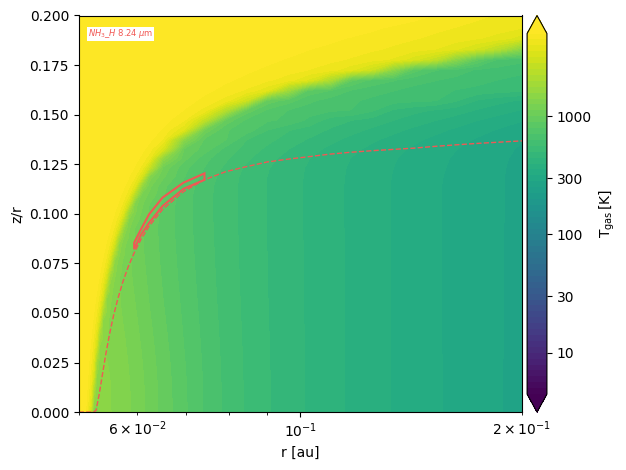

In [10]:
plt.close('all')
plot_lineorigin(model, [['NH3_H', 8.24]])
plt.savefig('NH3_lineorigin.png')

PLOT: plot_avgabun ...
PLOT: plot_abunvert ...


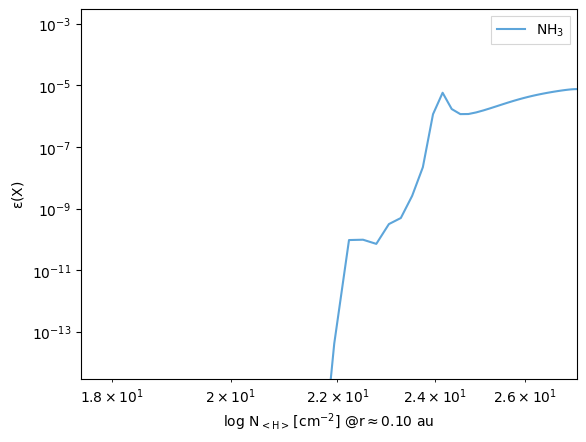

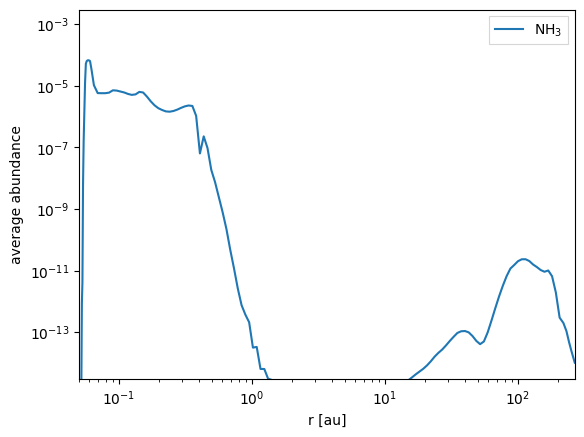

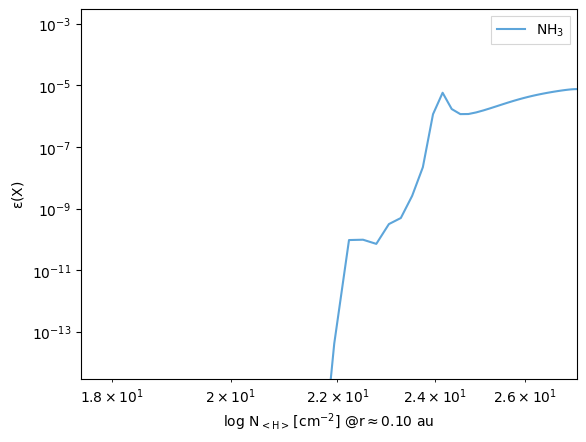

In [25]:
pp = pplot.Plot(None)
# plot_abundance(m, 'NH3')
cbticks = [10, 30, 100, 300, 1000]
# pp.plot_line_origin(m,['NH3_H', 8.24],field=m.tg,
#                             label=r"$\mathrm{T_{gas}\,[K]}$",zlim=[5, 5e3],extend="both",cb_format="%.0f",zr=True,xlog=True,
#                             xlim=[None,0.2],ylim=[None,0.2],
#                             clevels=cbticks,  # explictly set ticks for the cbar
#                             clabels=map(str, cbticks),
#                             showContOrigin=False,showRadialLines=False)
pp.plot_avgabun(m, ['NH3'],ylim=[3.e-15,3.e-3], xlog=True)
pp.plot_abunvert(m, .1, ['NH3'],ylim=[3.e-15,3.e-3], xlog=True)

PLOT: plot_avgabun ...


TypeError: can only concatenate str (not "list") to str

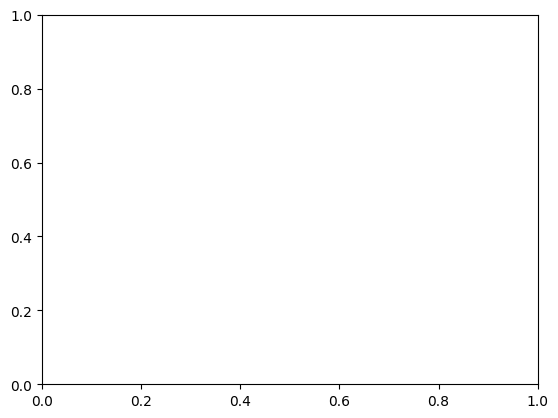

In [14]:
pp.plot_avgabun(m, ['NH3_H'])

READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\Species.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\Elements.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\SED.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\SEDana.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\image.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.5_CO_0.45\Parameter.out  ...
INFO: Reading time:  26.37 s
 
PLOT: plot_abuncont ...


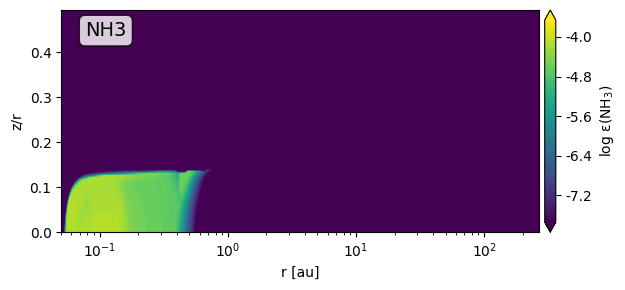

READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\Species.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\Elements.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\SED.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\SEDana.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\image.out  ...
READ: Reading File:  ./models/C_-0.5_O_-0.25_CO_0.2570\Parameter.out  ...
INFO: Reading time:  26.29 s
 
PLOT: plot_abuncont ...


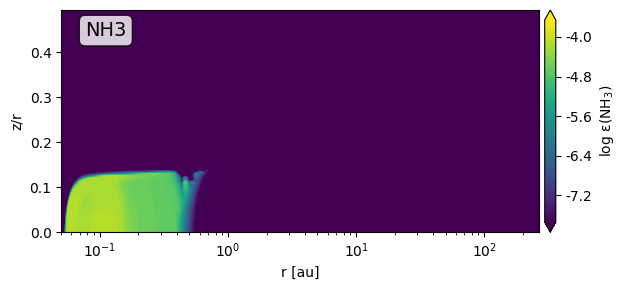

READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\Species.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\Elements.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\SED.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\SEDana.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\image.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.0_CO_0.145\Parameter.out  ...
INFO: Reading time:  26.04 s
 
PLOT: plot_abuncont ...


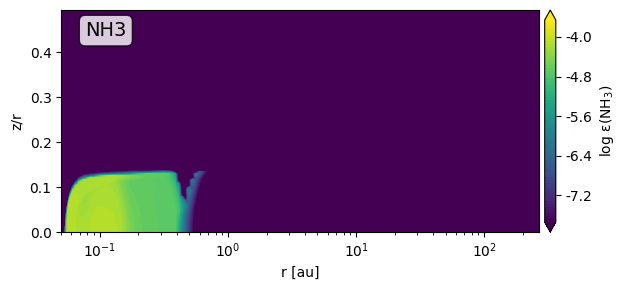

READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\Species.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\Elements.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\SED.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\SEDana.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\image.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.25_CO_0.0813\Parameter.out  ...
INFO: Reading time:  26.05 s
 
PLOT: plot_abuncont ...


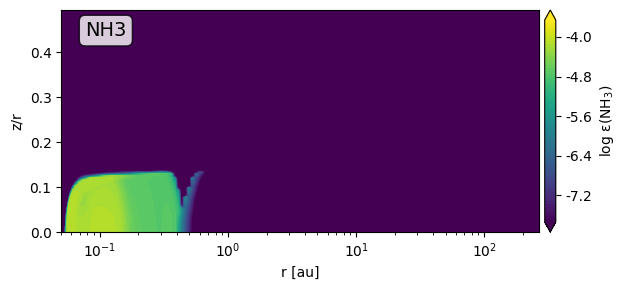

READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\Species.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\Elements.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\SED.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\SEDana.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\image.out  ...
READ: Reading File:  ./models/C_-0.5_O_0.5_CO_0.045\Parameter.out  ...
INFO: Reading time:  26.02 s
 
PLOT: plot_abuncont ...


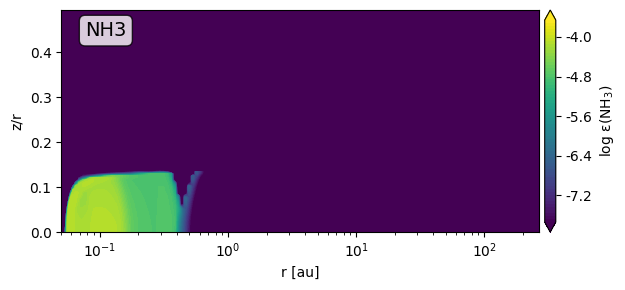

READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\Species.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\Elements.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\SED.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\SEDana.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\image.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.5_CO_0.813\Parameter.out  ...
INFO: Reading time:  25.62 s
 
PLOT: plot_abuncont ...


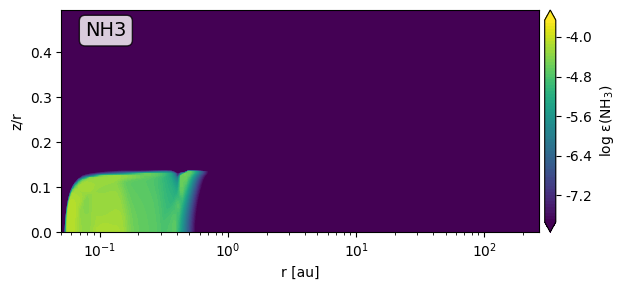

READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\Species.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\Elements.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\SED.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\SEDana.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\image.out  ...
READ: Reading File:  ./models/C_-0.25_O_-0.25_CO_0.45\Parameter.out  ...
INFO: Reading time:  26.08 s
 
PLOT: plot_abuncont ...


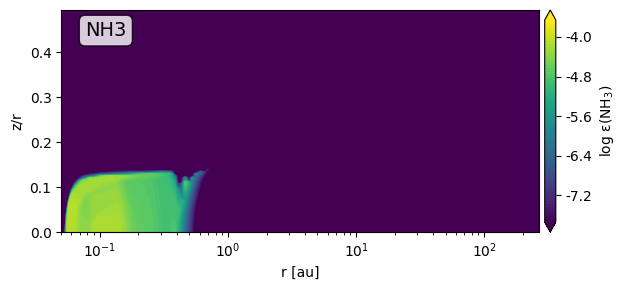

READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\Species.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\Elements.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\SED.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\SEDana.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\image.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.0_CO_0.257\Parameter.out  ...
INFO: Reading time:  25.49 s
 
PLOT: plot_abuncont ...


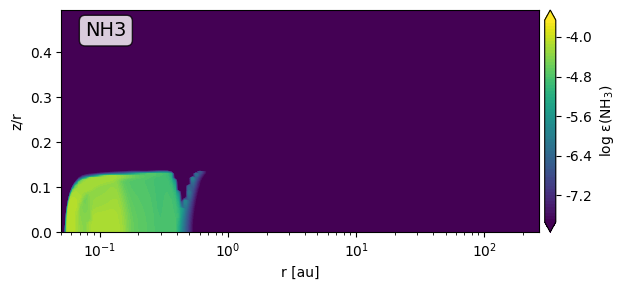

READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\Species.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\Elements.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\SED.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\SEDana.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\image.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.25_CO_0.145\Parameter.out  ...
INFO: Reading time:  18.48 s
 
PLOT: plot_abuncont ...


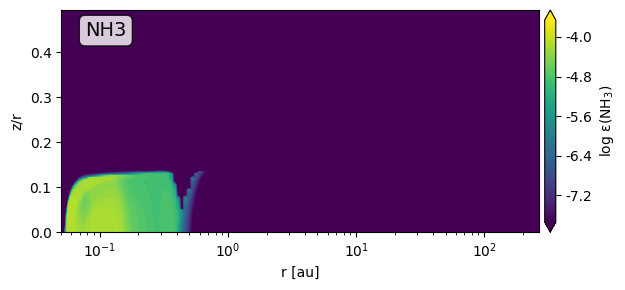

READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\ProDiMo.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\Species.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\FlineEstimates.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\Elements.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\dust_opac.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\StarSpectrum.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\SED.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\SEDana.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\image.out  ...
READ: Reading File:  ./models/C_-0.25_O_0.5_CO_0.0813\Parameter.out  ...
INFO: Reading time:  18.32 s
 
PLOT: plot_abuncont ...


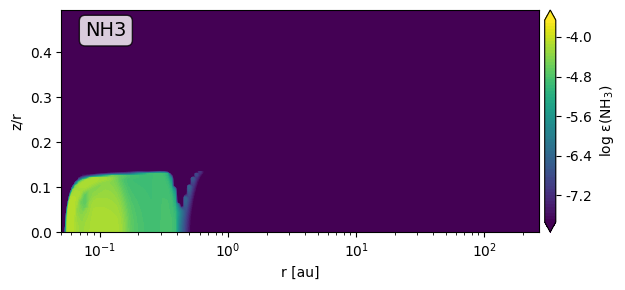

READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\SED.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\image.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.5_CO_1.445\Parameter.out  ...
INFO: Reading time:  18.11 s
 
PLOT: plot_abuncont ...


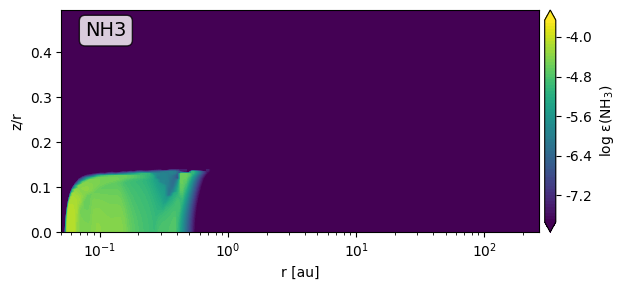

READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\SED.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\image.out  ...
READ: Reading File:  ./models/C_0.0_O_-0.25_CO_0.813\Parameter.out  ...
INFO: Reading time:  18.40 s
 
PLOT: plot_abuncont ...


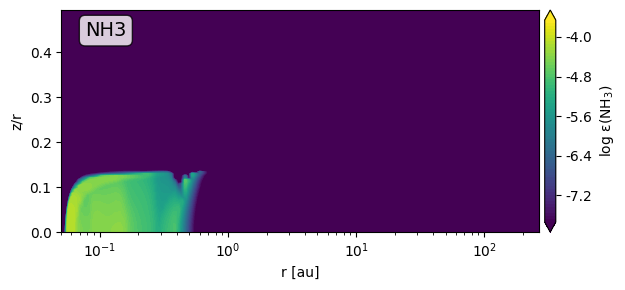

READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\SED.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\image.out  ...
READ: Reading File:  ./models/C_0.0_O_0.0_CO_0.45\Parameter.out  ...
INFO: Reading time:  18.42 s
 
PLOT: plot_abuncont ...


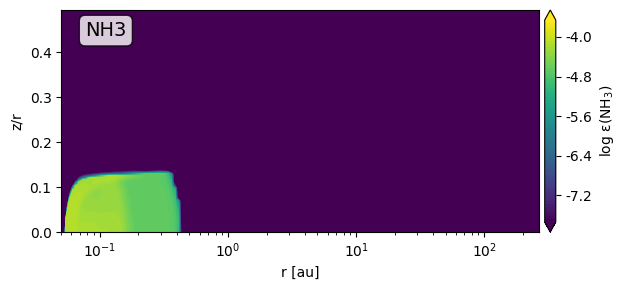

READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\SED.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\image.out  ...
READ: Reading File:  ./models/C_0.0_O_0.25_CO_0.257\Parameter.out  ...
INFO: Reading time:  17.68 s
 
PLOT: plot_abuncont ...


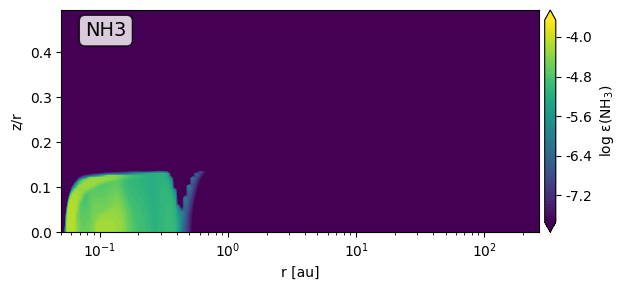

READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\Species.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\Elements.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\dust_opac.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\SED.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\SEDana.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\image.out  ...
READ: Reading File:  ./models/C_0.0_O_0.5_CO_0.145\Parameter.out  ...
INFO: Reading time:  17.80 s
 
PLOT: plot_abuncont ...


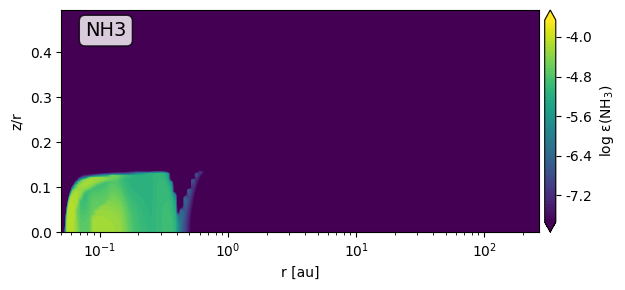

READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\Species.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\Elements.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\dust_opac.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\SED.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\SEDana.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\image.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.5_CO_2.570\Parameter.out  ...
INFO: Reading time:  17.04 s
 
PLOT: plot_abuncont ...


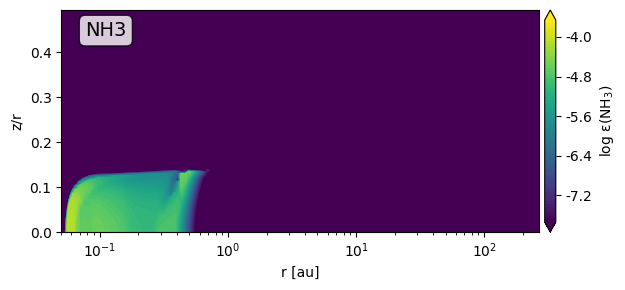

READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\Species.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\Elements.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\dust_opac.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\SED.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\SEDana.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\image.out  ...
READ: Reading File:  ./models/C_0.25_O_-0.25_CO_1.445\Parameter.out  ...
INFO: Reading time:  16.86 s
 
PLOT: plot_abuncont ...


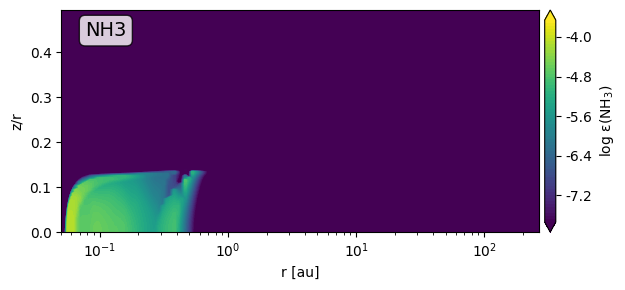

READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\Species.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\Elements.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\dust_opac.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\SED.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\SEDana.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\image.out  ...
READ: Reading File:  ./models/C_0.25_O_0.0_CO_0.813\Parameter.out  ...
INFO: Reading time:  16.85 s
 
PLOT: plot_abuncont ...


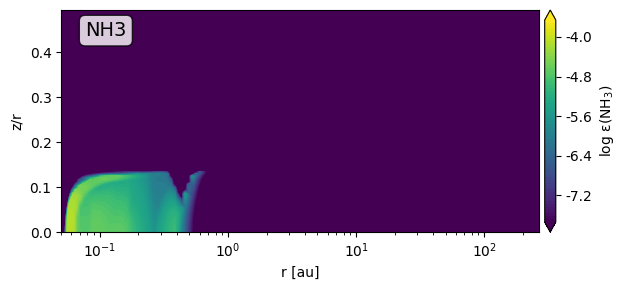

READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\Species.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\Elements.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\dust_opac.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\SED.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\SEDana.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\image.out  ...
READ: Reading File:  ./models/C_0.25_O_0.25_CO_0.45\Parameter.out  ...
INFO: Reading time:  17.04 s
 
PLOT: plot_abuncont ...


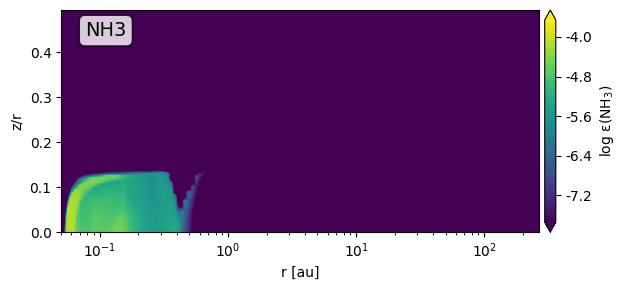

READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\Species.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\Elements.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\dust_opac.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\SED.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\SEDana.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\image.out  ...
READ: Reading File:  ./models/C_0.25_O_0.5_CO_0.2570\Parameter.out  ...
INFO: Reading time:  16.94 s
 
PLOT: plot_abuncont ...


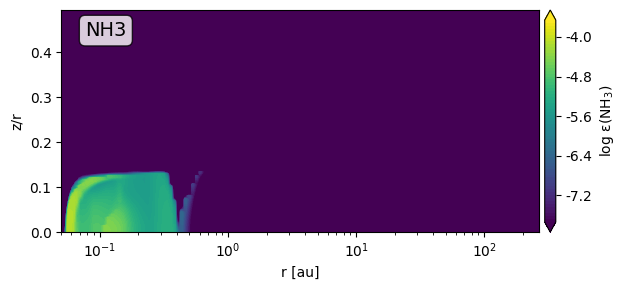

READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\Species.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\Elements.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\dust_opac.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\SED.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\SEDana.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\image.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.5_CO_4.57\Parameter.out  ...
INFO: Reading time:  17.16 s
 
PLOT: plot_abuncont ...


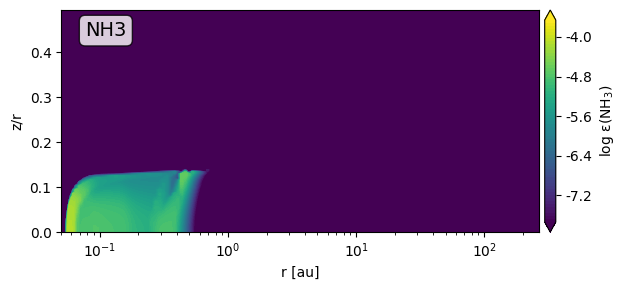

READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\Species.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\Elements.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\dust_opac.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\SED.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\SEDana.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\image.out  ...
READ: Reading File:  ./models/C_0.5_O_-0.25_CO_2.570\Parameter.out  ...
INFO: Reading time:  17.48 s
 
PLOT: plot_abuncont ...


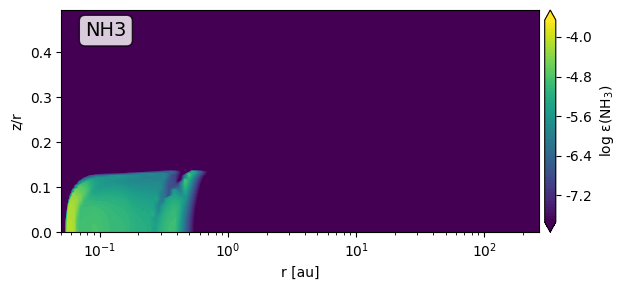

READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\Species.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\Elements.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\dust_opac.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\SED.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\SEDana.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\image.out  ...
READ: Reading File:  ./models/C_0.5_O_0.0_CO_1.445\Parameter.out  ...
INFO: Reading time:  17.44 s
 
PLOT: plot_abuncont ...


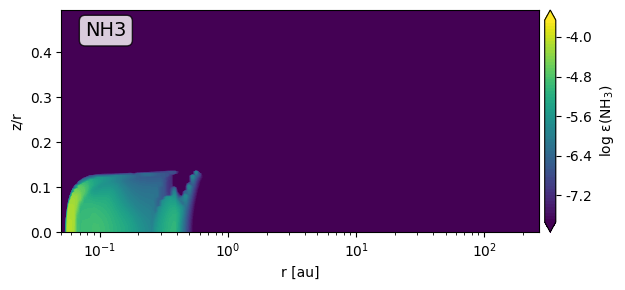

READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\Species.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\Elements.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\dust_opac.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\SED.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\SEDana.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\image.out  ...
READ: Reading File:  ./models/C_0.5_O_0.25_CO_0.813\Parameter.out  ...
INFO: Reading time:  17.22 s
 
PLOT: plot_abuncont ...


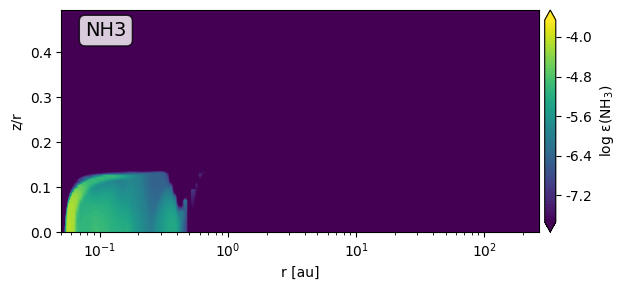

READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\ProDiMo.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\Species.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\FlineEstimates.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\Elements.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\dust_opac.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\dust_sigmaa.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\StarSpectrum.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\SED.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\SEDana.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\image.out  ...
READ: Reading File:  ./models/C_0.5_O_0.5_CO_0.45\Parameter.out  ...
INFO: Reading time:  17.00 s
 
PLOT: plot_abuncont ...


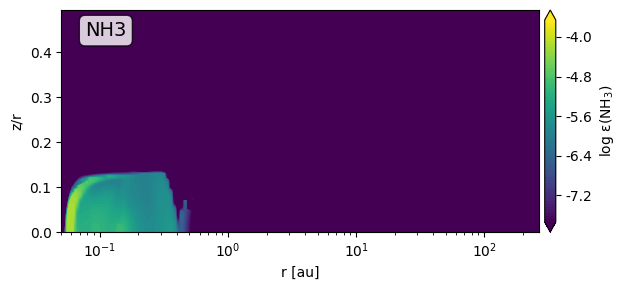

In [7]:
import pickle
with open('ModelData.pkl', 'rb') as f:
    df = pickle.load(f)
    
for model in df['Model Name']:
    m = pread.read_prodimo('./models/'+model)
    plot_abundance(m, 'NH3')

### Disk Information

PLOT: plot_cont ...
PLOT: plot_cont ...


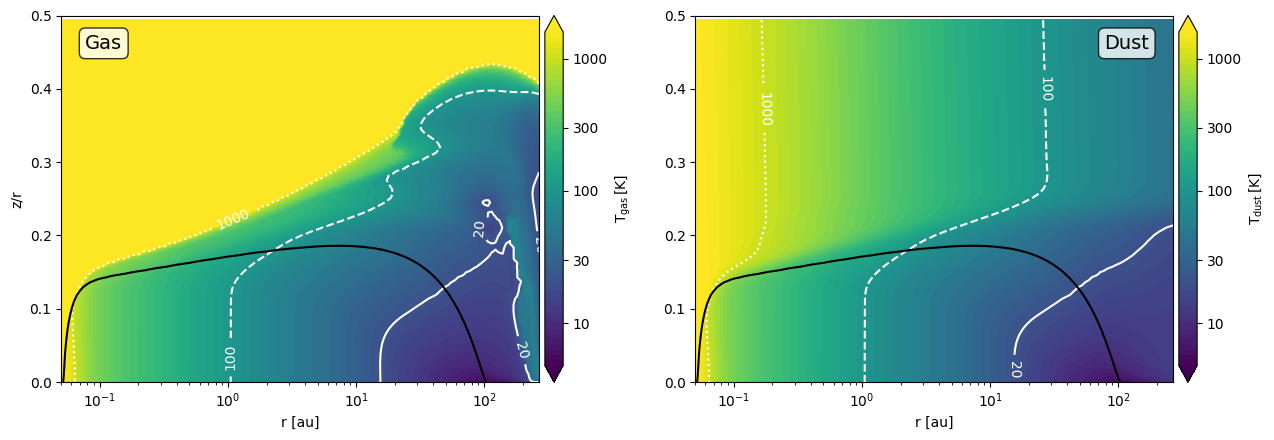

PLOT: plot_cont ...
PLOT: plot_cont ...


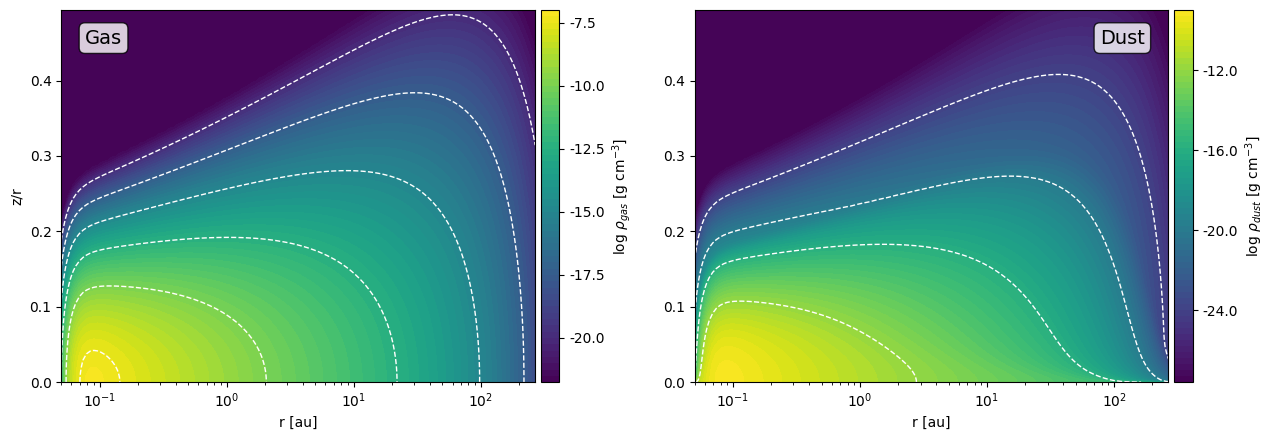

PLOT: plot_abuncont ...
PLOT: plot_abuncont ...


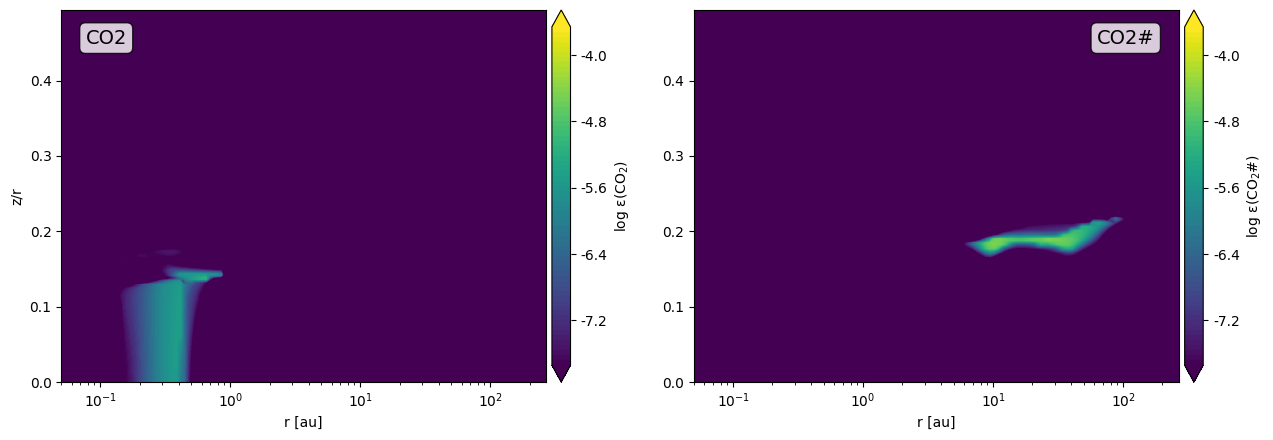

In [16]:
plt.close('all')
plot_temp(model)
plot_density(model)
plot_abundance(model, specie="CO2", includeIce=True)

### Spectrum Information

In [ ]:
wlrange = [13, 16]

In [ ]:
# species = [est.ident for est in model.lineEstimates]
# species = sorted(list(set(species)))
# species_with_lines = list()
# species_strong_lines = list()
# for specie in species:
#     molecule_spec = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True)
#     if np.sum(molecule_spec[1]) > 0:
#         species_with_lines.append(specie)
#         species_strong_lines.append(
#             sorted([line for line in model.selectLineEstimates(ident=specie, wlrange=wlrange) if line.flux > 1e-20],
#                    key=lambda x: x.flux, reverse=True))
# clear_output()

In [ ]:
species = [est.ident for est in model.lineEstimates]
species = sorted(list(set(species)))
species_with_lines = list()
species_strong_lines = list()
number_of_lines = list()
for specie in species:
    lines = sorted([line for line in model.selectLineEstimates(ident=specie, wlrange=wlrange) if line.flux > 1e-20],
                   key=lambda x: x.flux, reverse=True) #sorting in line strength
    #Checking if the list of lines is empty
    if lines:
        species_with_lines.append(specie)
        species_strong_lines.append(lines)
        number_of_lines.append(len(lines))
clear_output()

In [ ]:
prodimo_flux = [flux_prodimo(model, specie, wlrange) for specie in species_with_lines]
data = {
    "Specie": species_with_lines,
    "Number of Lines": number_of_lines,
    "Spectral Line": species_strong_lines,
    "Prodimo Flux (W m^-2)": prodimo_flux
}
df = pd.DataFrame(data)
clear_output()

In [ ]:
print(df)
# for lines in df['Spectral Line']:
#     fig,ax = plt.subplots(figsize=(14,5))
#     _, flux = convolve(model.FLiTsSpec.wl, model.FLiTsSpec.flux, 3000)
#     wl, flux_cont = convolve(model.FLiTsSpec.wl, model.FLiTsSpec.flux_cont, 3000)
#     flux -= flux_cont
#     ax.plot(wl, flux)
#     ax.set_ylabel('Flux [Jy]')
#     ax.set_xlabel(r'Wavelength [$\mu$m]')
#     ax.set_xlim(wlrange)
#     ax.set_ylim(0,0.02)
#     for line in lines[:10]:
#         ax.axvline(x=line.wl, color='r')
#     ax.set_title(lines[0].ident)
#     plt.show()

In [ ]:
plt.close('all')
fig,ax = plt.subplots(figsize=(14,5))
wl, flux, flux_cont = model.FLiTsSpec.convolve(3000, contReturn=True)
flux -= flux_cont
ax.plot(wl, flux)
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.02)
plt.show()

In [ ]:
plt.close('all')
total_spec = None
fig,ax = plt.subplots(figsize=(14,5))
for index, specie in enumerate(species_with_lines):
    spec = model.gen_specFromLineEstimates(ident=specie, wlrange=wlrange, noCont=True, unit='Jy')
    if total_spec is None:
        total_spec = spec[1]
    else:
        total_spec += spec[1]
    ax.fill_between(spec[0], 0, total_spec, label=specie, zorder=len(species_with_lines) - index)
clear_output()
# ax.plot(spec[0], total_spec, linestyle='--', color='black')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.02)
ax.legend(loc='best')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(14,5))
ax.plot(spec[0], total_spec, label='Prodimo generated')
ax.plot(wl, flux*2, label='Flits x2')
ax.set_ylabel('Flux [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_xlim(wlrange)
ax.set_ylim(0,0.04)
ax.legend()
plt.show()

In [ ]:
plt.close('all')
plot_lineorigin(model, [['HCN_H', 14.03], ['CO2_H', 14.98]])
plot_abundance(model, 'HCN', includeIce=True)
plot_abundance(model, 'CO2', includeIce=True)
plot_abundance(model, 'C2H2', includeIce=True)

In [ ]:
curl -u niels:grid1brp -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.5_O_-0.5_CO_0.45.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.5_O_-0.25_CO_0.2570.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.5_O_0.0_CO_0.145.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.5_O_0.25_CO_0.0813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.5_O_0.5_CO_0.045.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.25_O_-0.5_CO_0.813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.25_O_-0.25_CO_0.45.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.25_O_0.0_CO_0.257.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.25_O_0.25_CO_0.145.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_-0.25_O_0.5_CO_0.0813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.0_O_-0.5_CO_1.445.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.0_O_-0.25_CO_0.813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.0_O_0.0_CO_0.45.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.0_O_0.25_CO_0.257.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.0_O_0.5_CO_0.145.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.25_O_-0.5_CO_2.570.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.25_O_-0.25_CO_1.445.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.25_O_0.0_CO_0.813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.25_O_0.25_CO_0.45.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.25_O_0.5_CO_0.2570.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.5_O_-0.5_CO_4.57.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.5_O_-0.25_CO_2.570.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.5_O_0.0_CO_1.445.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.5_O_0.25_CO_0.813.tar.gz -O https://www.astro.rug.nl/~arabhavi/grid1/gdr_1000_N/C_0.5_O_0.5_CO_0.45.tar.gz 